<a href="https://colab.research.google.com/github/1oneweeek/Pyt_MCL/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN(Generative Adversarial Network): 2-Player game

생성자(Generator)와 판별자(Discriminator) 두 개의 신경망이 적대적인 과정을 통해 함께 학습하여 데이터를 생성하고 평가하는 모델

1. Generator: player 1,
사실적인 이미지를 생성하여 Discriminator를 속이는 것이 목표. 무작위 noise나 랜덤한 입력을 받아 실제와 같은 데이터를 생성하려고 시도함.

2. Discriminator: player 2,
입력 이미지가 실제인지 거짓인지 구별하는 것이 목표
이미지가 generator가 만든 위조 이미지인지 아닌지를 가능한 잘 구별해내야함
실제 데이터는 1에 가깝게, 가짜 데이터는 0에 가까운 확률을 출력하도록 학습함

loss function:
생성자와 판별자는 각각의 목적 함수를 최적화하기 위해 학습됨

+ 생성자: loss function으로는 주로 생성된 데이터가 실제 데이터로 판별될 확률로그를 사용

+ 판별자: 생성된 가짜 데이터와 실제 데이터를 구별할 수 있도록 학습하며, 이때의 loss function은 주로 cross-entropy를 사용

In [1]:
import json
import os
import numpy as np
import csv
import easydict
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable

from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
from time import sleep
from torchvision import datasets


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

# MNIST 데이터셋 로드
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=32, shuffle=True)

# 모델 가중치 초기화
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4652375.97it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135217.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1092586.88it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6970555.71it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
# Generator:

class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.num_classes = 10 # 클래스 수, 10
        self.nz = 100 # 노이즈 수, 100
        self.input_size = (1,28,28)

        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)

        # noise와 label을 결합할 용도로 label embedding matrix 생성
        self.label_emb = nn.Embedding(10, 10)
        # 임베딩 파라미터를 선언한 후 forward -> (입력차원, 임베딩차원) 크기의 텐서가 출력
        # 입력텐서는 임베딩 벡터를 추출할 범주의 인덱스이므로 정수타입(LongTensor)
        # ex) forward 메소드에 (2,4) 크기의 텐서가 입력으로 들어가면 (2,4,10) 크기의 텐서가 출력

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )


    # weight_init: 정규분포를 따르는 랜덤한 값으로 모델 가중치 초기화
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # 순전파: input으로 noise(100차원의 벡터), label(10차원의 벡터)
    def forward(self, input, label):
        z = input.view(input.size(0), 100)  # noise(batch_size, 100)
        c = self.label_emb(label)  # label이 임베딩됨
        x = torch.cat([z, c], 1) # 임베딩 된 label과 noise를 결합함
        out = self.model(x) # 신경망모델에 입력으로 전달하여 MNIST 이미지 생성
        return out.view(x.size(0), 28, 28)

In [3]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10) # 크기가 10인 embedding 행렬: label을 벡터로 변환

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    # weight_init: 정규분포를 따르도록 모델의 가중치를 초기화
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = input.view(input.size(0), 784) # input을 784차원의 벡터로 변환
        c = self.label_emb(label) # label을 embedding하여 벡터화
        x = torch.cat([x, c], 1) # input과 embedded label을 결합
        out = self.model(x) # 이를 discriminator에 전달하여 출력 계산
        return out.squeeze()

In [4]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss() # loss function으로 bineary cross entroypy 사용
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)


def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()

    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()  # 원-핫 벡터 아님
    fake_images = generator(z, fake_labels)  # 가짜 이미지 생성

    validity = discriminator(fake_images, fake_labels)
    # discriminator에 가짜 이미지를 넣어 결과 출력.
    # 가짜가 라벨과 같다라고 하면 1, 아니면 0

    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    # discriminator의 출력을 1로 채워져 있는 label과 비교
    # 판별자가 가짜 이미지를 라벨과 같다 판단해서 1을 출력했다면 loss는 0에 가까워짐
    # 이를 generator가 학습함
    # 즉, 생성자는 판별자를 잘 속이는 방향(validity 가 1이 나오게)으로 학습
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()



def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # Train with real images
    # 진짜 이미지와 label을 discriminator에 넣음
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    # 판별자가 진짜 이미지를 진짜라고 맞추면 1을 출력하고 real_loss는 0이 됨

    # Train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()  # 임의의 noise 생성
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()

    fake_images = generator(z, fake_labels) # noise와 임의의 label을 input으로 넣음

    fake_validity = discriminator(fake_images, fake_labels)
    # generator가 생성한 이미지와 임의의 라벨을 discriminator에 넣어서 결과 출력 (0~1)

    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    # real_loss와 달리 torch.zeors를 사용해서 0으로 채워진 label을 줌
    # discriminator가 img와 label이 같다고 판단하면 1을 출력, 아니면 0을 출력함.
    # 판별자가 잘 맞췄을 때는 cross_entropy(1, 0) 이므로 fake_loss가 커짐
    # 판별자가 진짜 이미지가 아닌 generator가 생성한 가짜 이미지를 진짜로 판단했으므로 loss가 커짐.

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()



from torchvision.utils import make_grid

num_epochs = 100
n_critic = 5
display_step = 50
batch_size = 32
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(train_loader):

        step = epoch * len(train_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()

        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

        #writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': d_loss}, step)

        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).cuda()
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
         #   writer.add_image('sample_image', grid, step)
    print('Done!')

Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

(-0.5, 271.5, 31.5, -0.5)

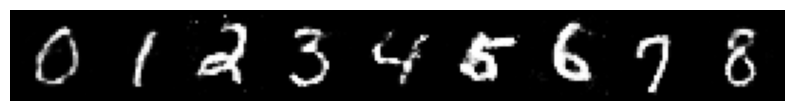

In [5]:
# 생성된 가짜 이미지를 그리드 형태로 시각화하여 출력

images = generator(z, labels).unsqueeze(1)
# 생성자에 입력으로 주어진 임의의 noise z와 labels를 사용하여 가짜 이미지 생성

grid = make_grid(images, nrow=10, normalize=True) # 생성된 가짜 이미지들을 그리드 형태로 만듦

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data.cpu(), cmap='binary')
ax.axis('off')